In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earthpulse/pytorch_eo/blob/master/examples/eurosat.ipynb)

In this example we are going to train an image classifier with the [EuroSAT](https://github.com/phelber/EuroSAT) dataset. Let's start by exploring our dataset. EuroSAT comes in two flavours: RGB or MS. EuroSATRGB will use RGB images (uint8 with 3 channels) built from the MS variant, that contains all the spectral bands (uint16, 13 bands). Let's start easily loading the EuroSAT RGB version. By default, the dataset will be downloaded, processed and split in train-validation-test (80%-20%-20%). Of course, you can modify this.

In [50]:
from pytorch_eo.datasets.eurosat import EuroSATRGB

ds = EuroSATRGB(batch_size=25, verbose=True) 

ds.setup()

data already extracted !
Number of images: 27000
training samples 16200
validation samples 5400
test samples 5400


All out datasets have a `DataFrame` containing the required data to train the model. In this case, the list of images and labels. Use this object to explore the dataset.

In [51]:
ds.df

,image,label
0,data/2750/AnnualCrop/AnnualCrop_401.jpg,0
1,data/2750/AnnualCrop/AnnualCrop_428.jpg,0
2,data/2750/AnnualCrop/AnnualCrop_1685.jpg,0
3,data/2750/AnnualCrop/AnnualCrop_1798.jpg,0
4,data/2750/AnnualCrop/AnnualCrop_2063.jpg,0
...,...,...
26995,data/2750/SeaLake/SeaLake_1423.jpg,9
26996,data/2750/SeaLake/SeaLake_1475.jpg,9
26997,data/2750/SeaLake/SeaLake_1616.jpg,9
26998,data/2750/SeaLake/SeaLake_1168.jpg,9


The task consists on the classification of images in 10 classes.

In [52]:
ds.num_classes, ds.classes

(10,
 ['AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'])

Let's visualize some samples from the dataset. You can extract data from the `Dataset`s objects or the `DataLoaders`. `PytorchEO` is designed to work with arbitrary number of inputs and outputs, so we use a `dict` to name the different tensors.

In [53]:
# extract the first sample of the training dataset (you can also access val_ds or test_ds for the other splits)

sample = ds.train_ds[0]

sample.keys(), sample['image'].shape, sample['label']

(dict_keys(['image', 'label']), (64, 64, 3), 7)

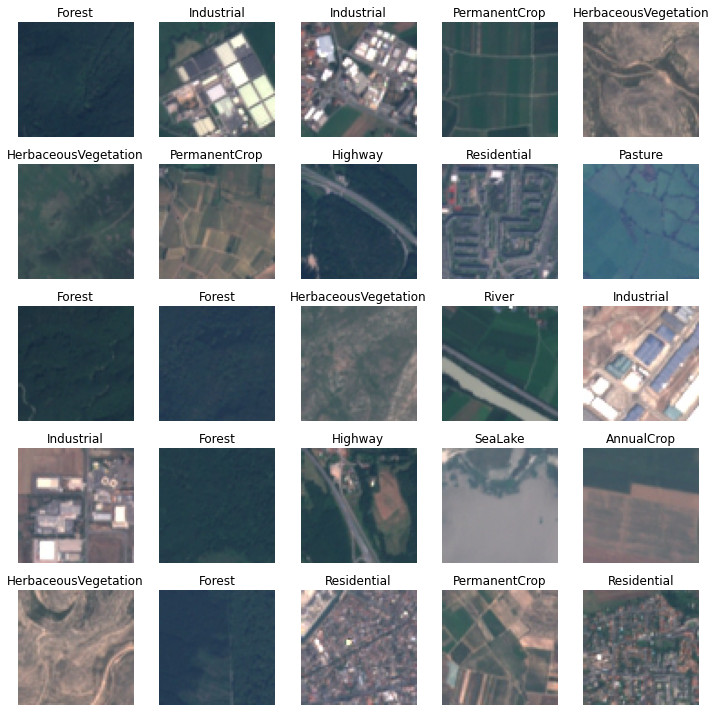

In [54]:
import matplotlib.pyplot as plt

# extract a batch of samples (you can also access val_dataloader or test_dataloader for the other splits)

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img)
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

Let's train an image classifier on this dataset. For that, we need a model. In this case, we are going to use a pretrained `resnet18` from the `timm` library. You can use external library or build your own models with `Pytorch`. 

In [55]:
from einops import rearrange
import torch
import timm 

class Model(torch.nn.Module):

    def __init__(self, in_chans=3, num_classes=10):
        super().__init__()
        self.model = timm.create_model(
            'resnet18',
            pretrained='imagenet',
            in_chans=in_chans,
            num_classes=num_classes
        )

    def forward(self, x): # DO NOT USE DICT, IT CANNOT BE EXPORTED WITH TORCHSCRIPT
        # here we have a tensor with dims (b h w c) and type uint8 (values between 0-255)
        # resnet18 is a CNN that need channels first
        x = rearrange(x, 'b h w c -> b c h w') # this cannot be exported with torchscript
        # our RGB image are uint8, need to be float in the range 0-1
        x = (x / 255).float()
        # now we can apply the model
        return self.model(x)

Once the `model` is defined, we need to define a `task`. In this case, we use the `ImageClassification` task.

In [56]:
from pytorch_eo.tasks.classification import ImageClassification

model = Model(in_chans=ds.in_chans, num_classes=ds.num_classes)

task = ImageClassification(model)

Check everything is working fine by sending a `batch` of inputs to the `task` before training.

In [57]:
out = task(imgs)

out.shape # this should match your expectations (batch size and number of classes)

torch.Size([25, 10])

Now, we can use `Pytorch Lightning` for training the `model` to solve the `task` on the given `dataset`.

In [58]:
import pytorch_lightning as pl

trainer = pl.Trainer(
    gpus=1,
    max_epochs=5,
    limit_train_batches=30,
    limit_val_batches=10
)

trainer.fit(task, ds)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Model            | 11.2 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Once the model is trained, we can evaluate it on the test set to compute the final metrics.

In [59]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8262962698936462, 'test_loss': 0.5445861220359802}
--------------------------------------------------------------------------------


[{'test_acc': 0.8262962698936462, 'test_loss': 0.5445861220359802}]

And also use it to predict labels on new images.

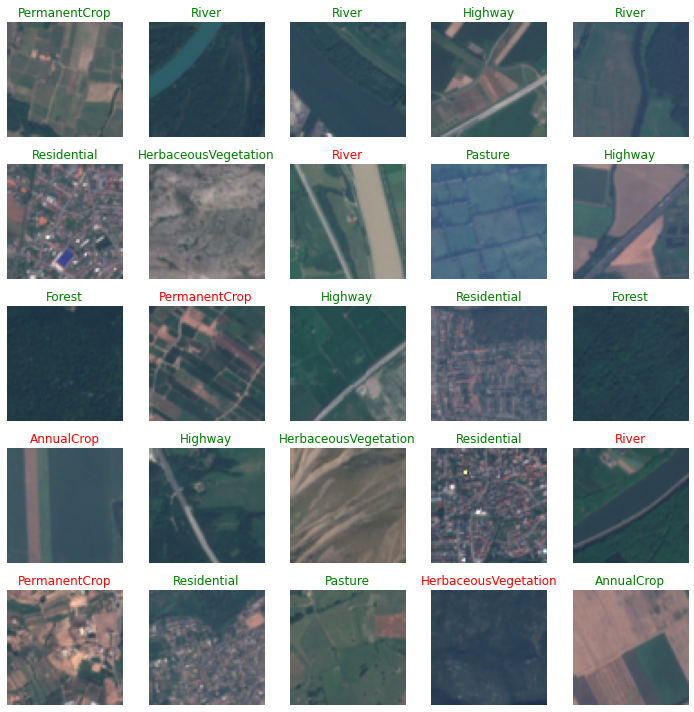

In [61]:
# extract batch from test dataloader

batch = next(iter(ds.test_dataloader(shuffle=True, batch_size=25)))
imgs, labels = batch['image'], batch['label']

# compute predictions

preds = task.predict(batch)
preds = torch.argmax(preds, axis=1)

# visualize predictions

fig = plt.figure(figsize=(10, 10))
for i, (img, label, pred) in enumerate(zip(imgs, labels, preds)):
	ax = plt.subplot(5, 5, i + 1)
	ax.imshow(img)
	gt = ds.classes[label.item()]
	pred = ds.classes[pred.item()]
	ax.set_title(gt, color="green" if gt == pred else 'red')
	ax.axis('off')
plt.tight_layout()
plt.show()